# Spooky Authors Identification

The project is a multiclass text classification project. Given some text the model should be able to correctly guess who's the author. With this project, for the first time, I used a semi-professional approach. In particular, I made an extensive use of Scikit-Learn pipelines, created checkpoints to save already processed feature matrices, performed proper feature selection, used dimensionality reduction techniques (NMF and TSVD), optimized parameters with RandomSearch, abused cross-validation and implemented Stacking! I stacked 4 different models trained on diverse sets of features.

## Things I learnt working on this project

- Stacking is useful but we should be careful to avoid overfitting. In particular, if we don't use cross validation to create meta features then there's a huge probability of overfitting because there is information leaking out of the training set. For this project SatckingCVClassifier wildly outperforms StackingClassifier (validation log-loss of 1.41 vs 0.66)
- All sklearn estimators handle multi-class problems automatically. Internally categories will be converted to integers if the algorithm supports native multi-class problems or one-hot encodings if the algorithm handles multi-class problems by transforming to binary. For example logistic regression, multilayer perceptron, Gaussian naive Bayes, and random forest are Inherently multiclass estimators. Others like SGD, or LinearSVC use one-vs-rest approach to handle multi-class but this, as mentioned above, will be handled internally by sklearn, so you don't need to do anything but pass multi-class labels (even as strings) in a single array of y to all estimators. Only thing where the user needs to explicitly convert labels to one-hot encoding is the multi-label problem, where more than one label can be predicted for a sample.
- Saving partial work and creating checkpoints can speed up work.
- SFS takes a lot of time if the number of features is not small
- I learnt how to use CloudWatch Alerts on AWS
- I learnt ho to use the screen command on a linux terminal (very useful if you want your commands to keep running even if you lose the ssh connection

## Potential Improvements to this Notebook

My objective was applying things I have learnt during the last months. I did not focus much on pure performance so I think I could improve this kernel:

- focusing more on feature engineering (I could have used also raw features instead of only using dimensionality reduction techniques) 
- devoting more time (and resources) to hyperparameter tuning. In particular, I could have explored more of the hyperparameter space with random search
- adding more an better models

## AutoML and Bayesian HyperParameter Optimization for the next project

I think autoML libraries have a great potential as they can really speed up data scientists in their work. Therefore I plan to start exploring autosklearn in my next project. 

## Import Libraries

In [1]:
## Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import string

## SkLearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel

## NLTK
import nltk
from nltk.corpus import stopwords

## Custom
from utils import get_num_columns, get_pos_tags_data, get_text_data

## MLXtend
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ColumnSelector
from mlxtend.classifier import StackingClassifier, StackingCVClassifier 

## Auto SKlearn
#from autosklearn.classification import AutoSklearnClassifier

## Pickle
import pickle

## Xgboost
from xgboost import XGBClassifier

## Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

## Seed pseudo random number generator
np.random.seed(42)

## Read the data

In [2]:
train = pd.read_csv("train.csv")
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Create basic text features

Let's create basic features such as number of characters, number of stopwords, etc...

In [3]:
## Define function I will apply to df
def text_features(df):
    ## Stopwords
    eng_stopwords = set(stopwords.words("english"))
    ## Number of characters
    df["n_characters"] = df.text.apply(len)
    ## Number of words
    df["n_words"] = df.text.apply(lambda x: len(x.split()))
    ## Number of unique words
    df["n_unique_words"] = df.text.apply(lambda x: len(set(x.split())))
    ## Number of StopWords
    df["n_stopwords"] = df.text.apply(lambda x: len([w for w in x.lower().split() if w in eng_stopwords]))
    ## Word density
    df["word_density"] = df.n_words/df.n_characters
    ## Punctuation count
    df["punctuation_count"] = df.text.apply(lambda x: len([character for character in x if character in string.punctuation]))
    ## Punctuation density
    df["punctuation_density"] = df.punctuation_count / df.n_characters
    ## Avg lenght of words in text
    df["avg_len_words"] = df.text.apply(lambda x: np.mean([len(w) for w in x.split()]))
    ## Number of words that start with upper case
    df["num_upper"] = df.text.apply(lambda x: len([w for w in x.split() if w.istitle()]))
    ## Number of words written in capital letters
    df["num_capital"] = df.text.apply(lambda x: len([w for w in x.split() if w.isupper()]))
    return df

## Apply function to df
train = text_features(train)
train.describe()

,n_characters,n_words,n_unique_words,n_stopwords,word_density,punctuation_count,punctuation_density,avg_len_words,num_upper,num_capital
count,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000
mean,149.057408,26.730477,23.136115,13.069820,0.181536,3.759283,0.028678,4.624827,2.176005,0.599213
std,106.800189,19.048353,13.457922,9.774894,0.018997,3.009744,0.020427,0.589194,1.965863,0.994366
min,21.000000,2.000000,2.000000,0.000000,0.086957,1.000000,0.000440,2.000000,0.000000,0.000000
25%,81.000000,15.000000,14.000000,7.000000,0.169492,2.000000,0.016949,4.250000,1.000000,0.000000
50%,128.000000,23.000000,21.000000,11.000000,0.180380,3.000000,0.023729,4.590909,2.000000,0.000000
75%,191.000000,34.000000,30.000000,17.000000,0.192308,5.000000,0.033898,4.952381,3.000000,1.000000
max,4663.000000,861.000000,429.000000,435.000000,0.337500,71.000000,0.483051,11.000000,46.000000,27.000000


In the cell below I just appreciate that the sample is balanced, i.e. the classes are distributed almost uniformly.

In [4]:
## Crosstab of author column
pd.crosstab(train.author, "id")

col_0,id
author,
EAP,7900
HPL,5635
MWS,6044


Now I write a function that maps tokens to part of speech tags and apply it to every piece of text. Have a look at the column pos_tags of the dataframe below.

In [5]:
def map_pos(text):
    ## Create a dictionary with key = word and value = pos
    d = dict(nltk.pos_tag(nltk.word_tokenize(text)))
    ## Tokenize
    tokens = nltk.word_tokenize(text)
    ## Map tokens to POS
    pos_raw = map(lambda x: d[x], tokens)
    ## Join tokens
    pos_text = " ".join(pos_raw)
    
    return pos_text

## Substitute words with part of speech tags
train["pos_tags"] = train.text.apply(map_pos)
train.head()

,id,text,author,n_characters,n_words,n_unique_words,n_stopwords,word_density,punctuation_count,punctuation_density,avg_len_words,num_upper,num_capital,pos_tags
0,id26305,"This process, however, afforded me no means of...",EAP,231,41,35,19,0.177489,7,0.030303,4.658537,3,2,"DT NN , RB , VBD PRP DT NNS IN VBG DT NNS IN P..."
1,id17569,It never once occurred to me that the fumbling...,HPL,71,14,14,8,0.197183,1,0.014085,4.142857,1,0,PRP RB RB VBD TO PRP IN DT NN MD VB DT JJ NN .
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,36,32,16,0.180000,5,0.025000,4.583333,1,0,"IN PRP$ JJ NN VBD DT JJ NN NN , IN WDT , IN PR..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,34,32,13,0.165049,4,0.019417,5.088235,4,0,WRB RB VBZ JJ IN PRP VBD IN NNP NNP IN DT JJ J...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,27,25,11,0.155172,4,0.022989,5.481481,2,0,"VBG NN RB , RB RB NN , DT NNP VBD PRP$ NNS : C..."


Below I change the data type of column author from text to category (category is more efficient). In addition, to avoid StandardScaler's warnings, I tranform integers into floats.

In [6]:
## author column to category type
train.author = train.author.astype("category")
X = train.drop(["id", "author"], axis="columns")
y = train.author

## Transform integers to floats in order to avoid StandardScaler's warnings
for col in X.select_dtypes(include=np.int64).columns:
    X[col] = X[col].astype(np.float64)
    
## Train Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X,y)

## Build $X$

To build the feature matrix I use pipelines and FunctionTransformers. I abused dimensionality reduction techniques to keep the model light. 

In [7]:
## Function Transformers - No Lambdas HERE!!!
get_pos = FunctionTransformer(get_pos_tags_data, validate=False)
get_numeric = FunctionTransformer(get_num_columns, validate=False)
get_txt = FunctionTransformer(get_text_data, validate=False)

## Numerical Features
numeric = make_pipeline(get_numeric, StandardScaler())

## Word Counts and TSVD
word_counts_tsvd = make_pipeline(get_txt, CountVectorizer(stop_words="english", ngram_range=(1,3)), TruncatedSVD(n_components=20))

## Word Counts and NMF
word_counts_nmf = make_pipeline(get_txt, CountVectorizer(stop_words="english", ngram_range=(1,3)), NMF(n_components=20))

## Word Frequencies and TSVD
word_freq_tsvd = make_pipeline(get_txt, TfidfVectorizer(stop_words="english", ngram_range=(1,3)), TruncatedSVD(n_components=20))

## Character Frequencies and TSVD
char_freq_tsvd = make_pipeline(get_txt, TfidfVectorizer(analyzer="char", ngram_range=(1,5)), TruncatedSVD(n_components=20))

## Parts of Speech Counts and TSVD
pos_counts_tsvd = make_pipeline(get_pos, CountVectorizer(stop_words="english", ngram_range=(1,3)), TruncatedSVD(n_components=20))

## Parts of Speech Counts and NMF
pos_counts_nmf = make_pipeline(get_pos, CountVectorizer(ngram_range=(1,3)), NMF(n_components=20))

## Parts of Speech Frequencies and TSVD
pos_freq_tsvd = make_pipeline(get_pos, TfidfVectorizer(stop_words="english", ngram_range=(1,3)), TruncatedSVD(n_components=20))

## Feature Union

union = FeatureUnion([("numeric", numeric),
                      ("word_counts_tsvd", word_counts_tsvd),
                      ("word_counts_nmf", word_counts_nmf),
                      ("word_freq_tsvd", word_freq_tsvd),
                      ("char_freq_tsvd", char_freq_tsvd),
                      ("pos_counts_tsvd", pos_counts_tsvd),
                      ("pos_counts_nmf", pos_counts_nmf),
                      ("pos_freq_tsvd", pos_freq_tsvd)])

## Apply Transformations
X_train = union.fit_transform(X_train)
X_valid = union.transform(X_valid)

## Check Point 1

I can start from here and load the data that have already been processed

In [8]:
## Save X and y to create a checkpoint.
pickle.dump(X, open("X.pkl", "wb"))
pickle.dump(y, open("y.pkl", "wb"))
pickle.dump(X_train, open("X_train.pkl","wb"))
pickle.dump(y_train, open("y_train.pkl","wb"))
pickle.dump(X_valid, open("X_valid.pkl","wb"))
pickle.dump(y_valid, open("y_valid.pkl","wb"))

In [2]:
## Load X and y
X = pickle.load(open("X.pkl", "rb"))
y = pickle.load(open("y.pkl", "rb"))
X_train = pickle.load(open("X_train.pkl", "rb"))
y_train = pickle.load(open("y_train.pkl", "rb"))
X_valid = pickle.load(open("X_valid.pkl", "rb"))
y_valid = pickle.load(open("y_valid.pkl", "rb"))

## Stacking Strategy

I want to train different algorithms on different sets of features and then apply stacking to appreciate the performance improvement. You get the most out of stacking when you use different algos trained on different features, training sets or hyperparameters. I do not pick features manually but I use automatic feature selection steps in my pipelines. I used dimensionality reduction techniques to build a light model.

### Base Learner 1 - Gaussian Naive Bayes

Naive Bayes is a very common choice when the aim is text classification. It is usually very effective. Here I use a Sequential Feature Selector (SFS) to select the best 75% of features. SFS is a wrapper method for feature selection. Wrapper methods are those which marry the feature selection process to the type of model being built, evaluating feature subsets in order to detect the model performance between features, and subsequently select the best performing subset. In other words, instead of existing as an independent process taking place prior to model building, wrapper methods attempt to optimize feature selection process for a given machine learning algorithm in tandem with this algorithm.

In [10]:
## Print the shape of our X matrix
print("shape of X: ", X_train.shape)
## Print the number of features that automatic feature selection should use
n_features = int(X_train.shape[1] * .7)
print("SFS max n. of features: ", n_features)

shape of X:  (14684, 150)
SFS max n. of features:  105


In [11]:
## Fit Sequential Feature Selector
sfs = SFS(GaussianNB(), k_features=n_features, scoring="neg_log_loss", n_jobs=-1, verbose=1)
sfs.fit(X_train, y_train)
## Create array of selected Features
feature_subsets_bl1 =  pd.DataFrame.from_dict(sfs.subsets_, orient="index")
## Choose the feature set with the highest negative loss
selected_features_bl1 = feature_subsets_bl1[feature_subsets_bl1.avg_score == feature_subsets_bl1.avg_score.max()]["feature_idx"].values
## Dump main results
pickle.dump(selected_features_bl1, open("selected_features_bl1.pkl","wb"))
pickle.dump(feature_subsets_bl1, open("feature_subsets_bl1.pkl","wb"))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.3s finished
Features: 1/105[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 149 out of 149 | elapsed:    2.1s finished
Features: 2/105[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:    2.1s finished
Features: 3/105[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:    2.2s finished
Features: 4/105[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: 

log loss: 0.8447. See the Confusion Matrix below


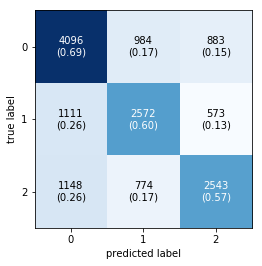

In [14]:
## Load selected_features
selected_features_bl1 = pickle.load(open("selected_features_bl1.pkl","rb"))

## Pipeline
best_bl1 = make_pipeline(ColumnSelector(cols=selected_features_bl1[0]),
                         GaussianNB())

## Cross Validaton
scores = cross_val_score(best_bl1, X_train, y_train, scoring="neg_log_loss", cv=3)
print("log loss: {:.4f}. See the Confusion Matrix below".format(np.mean(np.abs(scores))))

## Cross_val_predict with pipeline
bl1_pred = cross_val_predict(best_bl1, X_train, y_train, n_jobs=-1)

## Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, bl1_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=True)
plt.show()

In [24]:
## Fit and save best estimator
best_bl1.fit(X_train,y_train)
pickle.dump(best_bl1, open("best_bl1.pkl", "wb"))

### Base Learner 2 - Regularized Logistic Regression

Here I use a LogisticRegression with l1 norm and SelectFromModel to choose the best 105 features to feed the RandomForest with.

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.9min finished


Log loss of best estimator: -0.7616


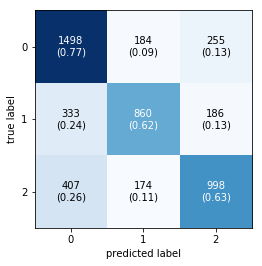

In [16]:
## Classifier
bl2 = make_pipeline(SelectFromModel(LogisticRegression(penalty="l1", n_jobs=-1), max_features=n_features, threshold=-np.inf),
                    LogisticRegression(n_jobs=-1))

## Random grid for C
c_values = np.linspace(start=0.05, stop=0.95, num=40)
random_grid = {'logisticregression__C': c_values}

## RandomSearch
random_search = RandomizedSearchCV(bl2, random_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1, refit=True, n_iter=25, cv=3)
random_search.fit(X_train, y_train)

## Get fitted best estimator and print log loss (to get best parameters type: random_search.best_params_)
best_bl2 = random_search.best_estimator_
print("Log loss of best estimator: {:.4f}".format(random_search.best_score_))

## Plot Confusion Matrix
conf_matrix = confusion_matrix(y_valid, best_bl2.predict(X_valid))
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=True)
plt.show()

In [17]:
## Save best estimator
pickle.dump(best_bl2, open("best_bl2.pkl", "wb"))

### Base Learner 3 - Random Forest Classifier
Here I use a RidgeClassifier (l2 norm) and SelectFromModel to choose the best 105 features to feed the RandomForest with.

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.5min finished


Log loss of best estimator: -0.9670


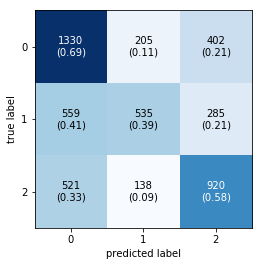

In [18]:
## Pipeline
bl3 = make_pipeline(SelectFromModel(RidgeClassifier(), max_features=n_features, threshold=-np.inf),
                    RandomForestClassifier(n_jobs=-1))

## Random grid
n_estimators = list(range(100,1000, 20))
max_depth = list(range(1,20,1))
min_samples_split = np.linspace(0.1, 0.7, 7, endpoint=True)
min_samples_leaf = np.linspace(0.1, 0.3, 5, endpoint=True)
max_features = np.linspace(0.1, 0.8, 8, endpoint=True)

random_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__max_features': max_features}

## RandomSearch
random_search = RandomizedSearchCV(bl3, random_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1, refit=True, n_iter=25, cv=3)
random_search.fit(X_train,y_train)

## Get fitted best estimator and print log loss (to get best parameters type: random_search.best_params_)
best_bl3 = random_search.best_estimator_
print("Log loss of best estimator: {:.4f}".format(random_search.best_score_))

## Plot Confusion Matrix
conf_matrix = confusion_matrix(y_valid, best_bl3.predict(X_valid))
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=True)
plt.show()

In [19]:
## Save best estimator
pickle.dump(best_bl3, open("best_bl3.pkl", "wb"))

### Base Learner 4 - XGBoost Classifier
Here I use a RandomForestClassifier and SelectFromModel to choose the best 105 features to feed XGBoost with.

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 10.9min finished


Log loss of best estimator: -0.6683


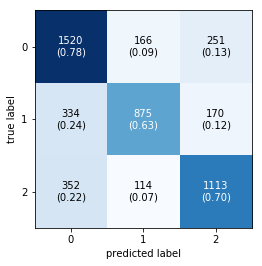

In [20]:
## Pipeline
bl4 = make_pipeline(SelectFromModel(RandomForestClassifier(n_jobs=-1), max_features=n_features, threshold=-np.inf),
                    XGBClassifier(n_jobs=-1))

## Random grid
n_estimators = list(range(100,1000, 20))
max_depth = list(range(1,20,1))
min_samples_split = np.linspace(0.1, 0.7, 7, endpoint=True)
subsample = np.linspace(0.7, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.1, 0.8, 8, endpoint=True)
learning_rate = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

random_grid = {'xgbclassifier__n_estimators': n_estimators,
               'xgbclassifier__max_depth': max_depth,
               'xgbclassifier__min_samples_split': min_samples_split,
               'xgbclassifier__subsample': subsample,
               'xgbclassifier__colsample_bytree': colsample_bytree,
               'xgbclassifier__learning_rate': learning_rate}

## RandomSearch
random_search = RandomizedSearchCV(bl4, random_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1, refit=True, n_iter=25, cv=3)
random_search.fit(X_train,y_train)

## Get fitted best estimator and print log loss (to get best parameters type: random_search.best_params_)
best_bl4 = random_search.best_estimator_
print("Log loss of best estimator: {:.4f}".format(random_search.best_score_))

## Plot Confusion Matrix
conf_matrix = confusion_matrix(y_valid, best_bl4.predict(X_valid))
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=True)
plt.show()

In [21]:
## Save best estimator
pickle.dump(best_bl4, open("best_bl4.pkl", "wb"))

## CheckPoint 2

In [22]:
## Load best models
best_bl1 = pickle.load(open("best_bl1.pkl", "rb"))
best_bl2 = pickle.load(open("best_bl2.pkl", "rb"))
best_bl3 = pickle.load(open("best_bl3.pkl", "rb"))
best_bl4 = pickle.load(open("best_bl4.pkl", "rb"))

## Correlation Between Base Learners

If we check the correlation between our base learners' predictions we see that we built a a truly diverse set of estimators (correlation is not very high). This means that stacking will be fruitful.

In [27]:
## Correlation between models

bl1_pred = best_bl1.predict(X_valid)
bl2_pred = best_bl2.predict(X_valid)
bl3_pred = best_bl3.predict(X_valid)
bl4_pred = best_bl4.predict(X_valid)

## Build DataFrame
preds = pd.DataFrame({"y_valid": y_valid, "best_bl1": bl1_pred,"best_bl2": bl2_pred, "best_bl3": bl3_pred, "best_bl4": bl4_pred})
preds.apply(LabelEncoder().fit_transform).corr()

,y_valid,best_bl1,best_bl2,best_bl3,best_bl4
y_valid,1.000000,0.450942,0.504696,0.344429,0.555186
best_bl1,0.450942,1.000000,0.652696,0.406469,0.597734
best_bl2,0.504696,0.652696,1.000000,0.379015,0.669569
best_bl3,0.344429,0.406469,0.379015,1.000000,0.451508
best_bl4,0.555186,0.597734,0.669569,0.451508,1.000000


In [28]:
## Validation Log Loss of Base Learners
print("Validation Score best_bl1:", log_loss(y_valid, best_bl1.predict_proba(X_valid)))
print("Validation Score best_bl2:", log_loss(y_valid, best_bl2.predict_proba(X_valid)))
print("Validation Score best_bl3:", log_loss(y_valid, best_bl3.predict_proba(X_valid)))
print("Validation Score best_bl4:", log_loss(y_valid, best_bl4.predict_proba(X_valid)))

Validation Score best_bl1: 0.8606561483392979
Validation Score best_bl2: 0.7531110256842791
Validation Score best_bl3: 0.9657618123427221
Validation Score best_bl4: 0.6651254765572898


## Stacking Classifier - XGBoostClassifier

The Stacking Classifier will be trained on meta-features but I will use probability distributions instead of predictions. In addition, I will include the original set features. This is important because raw features may add a context that's useful to get the most out of the set of meta-features. Finally I use StackingCVClassifier instead of StackingClassifier to avoid overfitting (see mlxtend docs for details).

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 70.1min finished


Log loss of best estimator: -0.6554


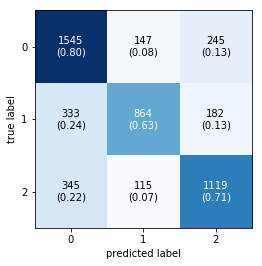

In [29]:
## Create Stacking Classifier
sclf = StackingCVClassifier([best_bl1, best_bl2, best_bl3, best_bl4],
                       meta_classifier=XGBClassifier(n_jobs=-1),
                       use_probas=True,
                       use_features_in_secondary=True)

## Random grid
n_estimators = list(range(100,1000, 20))
max_depth = list(range(1,20,1))
min_samples_split = np.linspace(0.1, 0.7, 7, endpoint=True)
min_samples_leaf = np.linspace(0.1, 0.3, 5, endpoint=True)
max_features = np.linspace(0.1, 0.8, 8, endpoint=True)

random_grid = {'meta-xgbclassifier__n_estimators': n_estimators,
               'meta-xgbclassifier__max_depth': max_depth,
               'meta-xgbclassifier__min_samples_split': min_samples_split,
               'meta-xgbclassifier__subsample': subsample,
               'meta-xgbclassifier__colsample_bytree': colsample_bytree,
               'meta-xgbclassifier__learning_rate': learning_rate}

## RandomSearch
random_search = RandomizedSearchCV(sclf, random_grid, scoring="neg_log_loss", n_jobs=-1, verbose=1, refit=True, n_iter=30, cv=3)

## Do not use y_train with dtype = categorical: StackingCVClassifier does not work with it
random_search.fit(X_train,y_train.values.astype("O"))

## Get fitted best estimator and print log loss (to get best parameters type: random_search.best_params_)
best_sclf = random_search.best_estimator_
print("Log loss of best estimator: {:.4f}".format(random_search.best_score_))

## Save best estimator
pickle.dump(best_sclf, open("best_sclf.pkl", "wb"))

## Plot Confusion Matrix
conf_matrix = confusion_matrix(y_valid, best_sclf.predict(X_valid))
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=True)
plt.show()